In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import itertools
from pprint import pprint

np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00000,0,1,Yes,Private,Urban,228.69000,36.60000,formerly smoked,1
1,51676,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked,1
2,31112,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked,1
3,60182,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes,1
4,1665,Female,79.00000,1,0,Yes,Self-employed,Rural,174.12000,24.00000,never smoked,1


In [4]:
data = data.drop(columns=['id'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
data.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [7]:
data.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [8]:
(data['gender'] == 'Other').sum()

1

In [9]:
data = data[data.gender != 'Other']

In [10]:
df_uniques = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns], columns=['Feature', 'Unique Values']).set_index('Feature')
df_uniques

,Unique Values
Feature,
gender,2
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3978
bmi,419


In [11]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'stroke']

In [12]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['work_type', 'smoking_status']

In [13]:
print([[i, list(data[i].unique())] for i in categorical_variables])

[['work_type', ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']], ['smoking_status', ['formerly smoked', 'never smoked', 'smokes', 'Unknown']]]


In [14]:
data = data[data.smoking_status != 'Unknown']
data.shape

(3565, 11)

In [15]:
numeric_variables = list(set(data.columns) - set(categorical_variables) - set(binary_variables))
numeric_variables

['bmi', 'age', 'avg_glucose_level']

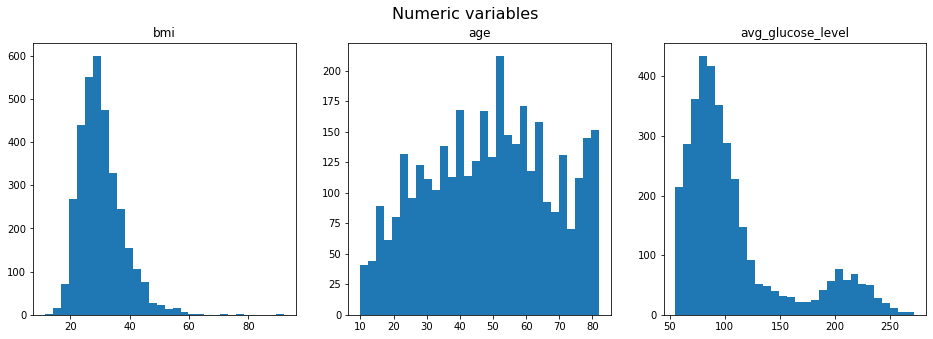

In [16]:
fig, axs = plt.subplots(1,3, figsize=(16,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, numeric_variables):
    ax.hist(data[feature], bins=30)
    ax.set_title(feature)
    
fig.suptitle('Numeric variables', fontsize=16)
plt.show()

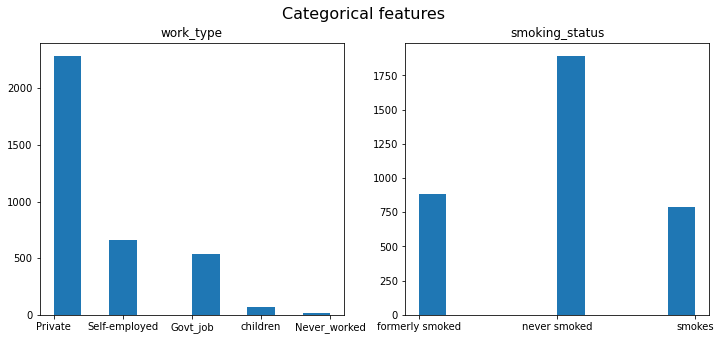

In [17]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, categorical_variables):
    ax.hist(data[feature])
    ax.set_title(feature)
    
fig.suptitle('Categorical features', fontsize=16)
plt.show()

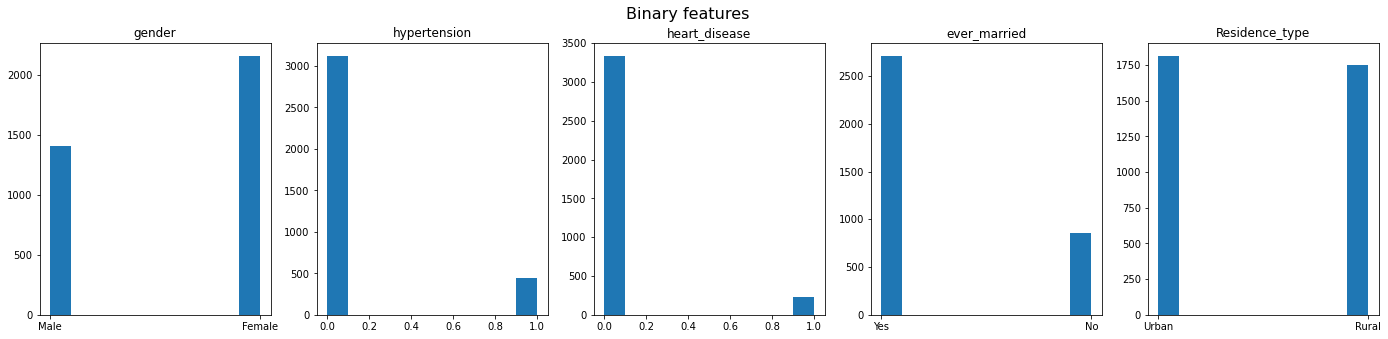

In [18]:
fig, axs = plt.subplots(1,5, figsize=(24,5))

axlist = axs.flatten()

binary_variables = binary_variables[:-1]

for ax, feature in zip(axlist, binary_variables):
    ax.hist(data[feature])
    ax.set_title(feature)
    
fig.suptitle('Binary features', fontsize=16)
plt.show()

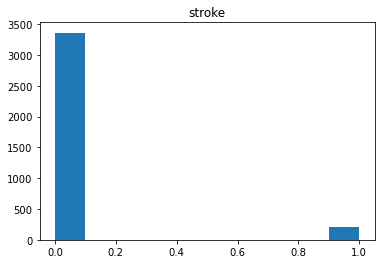

In [19]:
plt.hist(data.stroke)
plt.title('stroke')
plt.show()

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler

In [21]:
y = data['stroke'].reset_index(drop=True)
X = data[data.columns[:-1]].reset_index(drop=True)
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.00000,0,1,Yes,Private,Urban,228.69000,36.60000,formerly smoked
1,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked
2,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked
3,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes
4,Female,79.00000,1,0,Yes,Self-employed,Rural,174.12000,24.00000,never smoked


In [22]:
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('normalizer', PowerTransformer(method='box-cox')),
                            ('scaler', StandardScaler())
                           ])

cat_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

col_transformer = ColumnTransformer([('num_processing', num_transformer, numeric_variables),
                                     ('cat_processing', cat_transformer, (categorical_variables+binary_variables))])

In [23]:
test_data_trans = col_transformer.fit_transform(X)

In [24]:
transformed_cat_cols = col_transformer.named_transformers_['cat_processing'][0].get_feature_names_out(categorical_variables+binary_variables)

In [25]:
test_dataframe_trans = pd.DataFrame(test_data_trans, columns=[numeric_variables+transformed_cat_cols.tolist()])
test_dataframe_trans.head()

,bmi,age,avg_glucose_level,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_never smoked,smoking_status_smokes,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,Residence_type_Urban
0,0.97472,0.95832,1.77493,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000
1,-0.01634,0.65189,1.61510,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
2,0.47175,1.61274,0.33927,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000
3,0.71504,0.02911,1.36392,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000
4,-0.91672,1.56282,1.39121,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000


In [26]:
test_dataframe_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (bmi,)                          3565 non-null   float64
 1   (age,)                          3565 non-null   float64
 2   (avg_glucose_level,)            3565 non-null   float64
 3   (work_type_Never_worked,)       3565 non-null   float64
 4   (work_type_Private,)            3565 non-null   float64
 5   (work_type_Self-employed,)      3565 non-null   float64
 6   (work_type_children,)           3565 non-null   float64
 7   (smoking_status_never smoked,)  3565 non-null   float64
 8   (smoking_status_smokes,)        3565 non-null   float64
 9   (gender_Male,)                  3565 non-null   float64
 10  (hypertension_1,)               3565 non-null   float64
 11  (heart_disease_1,)              3565 non-null   float64
 12  (ever_married_Yes,)             35

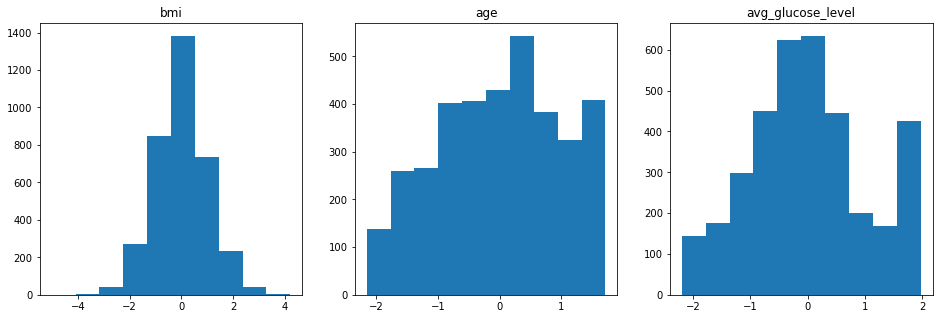

In [27]:
fig, axs = plt.subplots(1,3, figsize=(16,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, numeric_variables):
    ax.hist(test_dataframe_trans[feature])
    ax.set_title(feature)

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import joblib

In [29]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

train_index, test_index = next(sss.split(X, y))

X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2495, 10)
(2495,)
(1070, 10)
(1070,)


In [30]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

print(y_train.value_counts())
print(y_test.value_counts())

n_strokes = y_train.value_counts()[1]

0   0.94349
1   0.05651
Name: stroke, dtype: float64
0   0.94299
1   0.05701
Name: stroke, dtype: float64
0    2354
1     141
Name: stroke, dtype: int64
0    1009
1      61
Name: stroke, dtype: int64


In [31]:
pipe_lr_default = make_pipeline(col_transformer, LogisticRegression())
pipe_svm_default = make_pipeline(col_transformer, SVC(),)
pipe_rfc_default = make_pipeline(col_transformer, RandomForestClassifier())
pipe_mlp_default = make_pipeline(col_transformer, MLPClassifier())

pipes_default = [pipe_lr_default, pipe_svm_default, pipe_rfc_default, pipe_mlp_default]

default_models = [p.fit(X_train, y_train) for p in pipes_default]

C:\Users\Tuomas\python\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

In [33]:
default_metrics_in_sample = []

for m in default_models:    
    print(f'Classifier: {m[1]}\n')
    y_pred = m.predict(X_train)
    print(classification_report(y_train, y_pred, zero_division=0))
    default_metrics_in_sample.append([x[1] for x in precision_recall_fscore_support(y_train, y_pred, zero_division=0)])

Classifier: LogisticRegression()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2354
           1       0.00      0.00      0.00       141

    accuracy                           0.94      2495
   macro avg       0.47      0.50      0.49      2495
weighted avg       0.89      0.94      0.92      2495

Classifier: SVC()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2354
           1       0.00      0.00      0.00       141

    accuracy                           0.94      2495
   macro avg       0.47      0.50      0.49      2495
weighted avg       0.89      0.94      0.92      2495

Classifier: RandomForestClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2354
           1       1.00      1.00      1.00       141

    accuracy                           1.00      2495
   macro avg       1.00      1.00    

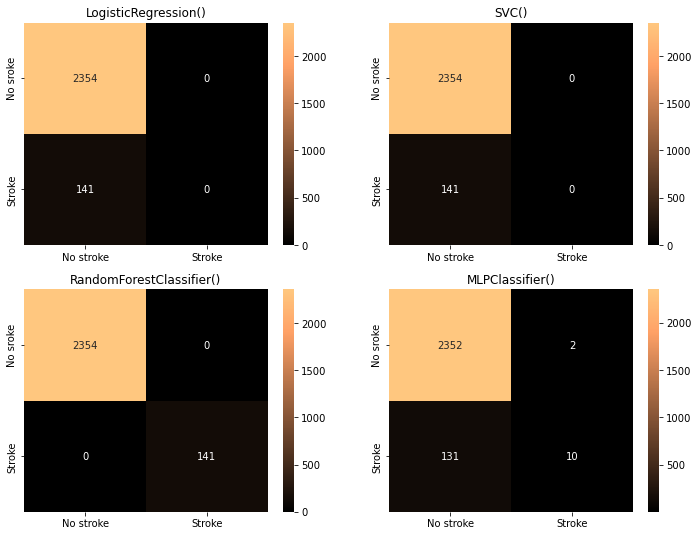

In [34]:
fig, axs = plt.subplots(2,2, figsize=(12,9))

axlist = axs.flatten()

for ax, m in zip(axlist, default_models):
    y_pred = m.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=['No stroke', 'Stroke'], yticklabels=['No sroke', 'Stroke'])
    ax.set_title(m[1])

In [35]:
default_metrics_out_of_sample = []

for m in default_models:    
    print(f'Classifier: {m[1]}\n')
    y_pred = m.predict(X_test)
    print(classification_report(y_test, y_pred,  zero_division=0))
    default_metrics_out_of_sample.append([x[1] for x in precision_recall_fscore_support(y_test, y_pred, zero_division=0)])

Classifier: LogisticRegression()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1009
           1       1.00      0.02      0.03        61

    accuracy                           0.94      1070
   macro avg       0.97      0.51      0.50      1070
weighted avg       0.95      0.94      0.92      1070

Classifier: SVC()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1009
           1       0.00      0.00      0.00        61

    accuracy                           0.94      1070
   macro avg       0.47      0.50      0.49      1070
weighted avg       0.89      0.94      0.92      1070

Classifier: RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1009
           1       1.00      0.03      0.06        61

    accuracy                           0.94      1070
   macro avg       0.97      0.52    

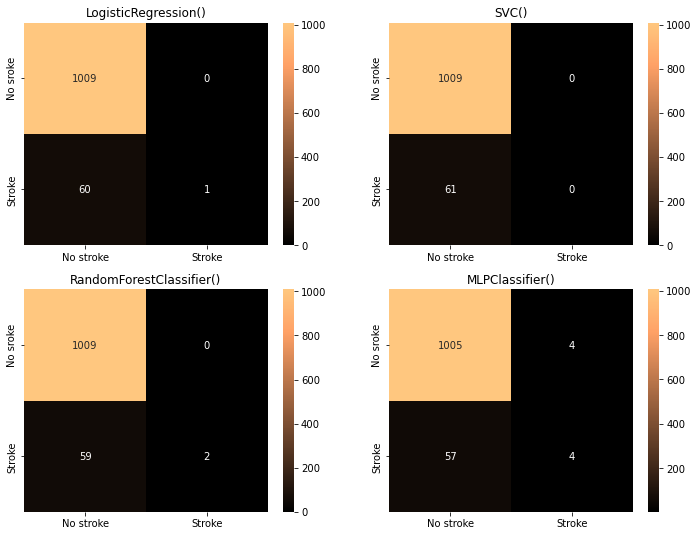

In [36]:
fig, axs = plt.subplots(2,2, figsize=(12,9))

axlist = axs.flatten()

for ax, m in zip(axlist, default_models):
    y_pred = m.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=['No stroke', 'Stroke'], yticklabels=['No sroke', 'Stroke'])
    ax.set_title(m[1])

In [37]:
def check_params_exist(estimator, params_keyword):
    all_params = estimator.get_params().keys()
    available_params = [x for x in all_params if params_keyword in x]
    if len(available_params)==0:
        return "No matching params found!"
    else:
        return available_params

In [38]:
pipe_lr = Pipeline([
                    ('col', col_transformer),
                    ('under_sampler', None),
                    ('over_sampler', SMOTEN()),
                    ('clf', LogisticRegression())
                    ])

pipe_svm = Pipeline([('col', col_transformer),
                    ('under_sampler', RandomUnderSampler()),
                    ('over_sampler', SMOTEN()),
                    ('clf', SVC())
                    ])

pipe_rfc = Pipeline([('col', col_transformer),
                    ('under_sampler', RandomUnderSampler()),
                    ('over_sampler', SMOTEN()),
                    ('clf', RandomForestClassifier())
                    ])

pipe_mlp = Pipeline([('col', col_transformer),
                    ('under_sampler', RandomUnderSampler()),
                    ('over_sampler', SMOTEN()),
                    ('clf', MLPClassifier())
                    ])

In [39]:
pprint(check_params_exist(pipe_mlp, 'clf'))

['clf',
 'clf__activation',
 'clf__alpha',
 'clf__batch_size',
 'clf__beta_1',
 'clf__beta_2',
 'clf__early_stopping',
 'clf__epsilon',
 'clf__hidden_layer_sizes',
 'clf__learning_rate',
 'clf__learning_rate_init',
 'clf__max_fun',
 'clf__max_iter',
 'clf__momentum',
 'clf__n_iter_no_change',
 'clf__nesterovs_momentum',
 'clf__power_t',
 'clf__random_state',
 'clf__shuffle',
 'clf__solver',
 'clf__tol',
 'clf__validation_fraction',
 'clf__verbose',
 'clf__warm_start']


In [40]:
grid_lr = {
           'col__num_processing__scaler': [StandardScaler(), MinMaxScaler()],
           'under_sampler': ['passthrough', RandomUnderSampler(sampling_strategy=0.1), RandomUnderSampler(sampling_strategy=0.3),
                                            RandomUnderSampler(sampling_strategy=0.5)],
           'over_sampler__sampling_strategy':[1.0, 0.8, 0.6],
           'clf__solver': ['liblinear'],
           'clf__penalty': ['l1', 'l2'],
           'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
          }

grid_svm = {
           'col__num_processing__scaler': [StandardScaler(), MinMaxScaler()],
           'under_sampler': ['passthrough', RandomUnderSampler(sampling_strategy=0.1), RandomUnderSampler(sampling_strategy=0.3),
                                            RandomUnderSampler(sampling_strategy=0.5)],
           'over_sampler__sampling_strategy':[1.0, 0.8, 0.6],
           'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
           'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
           'clf__class_weight': [None, 'balanced'],
           'clf__cache_size': [500]
          }

grid_rfc = {
           'col__num_processing__scaler': [StandardScaler(), MinMaxScaler()],
           'under_sampler': ['passthrough', RandomUnderSampler(sampling_strategy=0.1), RandomUnderSampler(sampling_strategy=0.3),
                                            RandomUnderSampler(sampling_strategy=0.5)],
           'over_sampler__sampling_strategy':[1.0, 0.8, 0.6],
           'clf__max_depth': [3, 5, 7],
           'clf__max_features': [2, 3, 4],
           'clf__min_samples_leaf': [2, 4],
           'clf__min_samples_split': [10, 15, 20],
           'clf__n_estimators': [10, 20, 30]
          }

grid_mlp = {
           'col__num_processing__scaler': [StandardScaler(), MinMaxScaler()],
           'under_sampler': ['passthrough', RandomUnderSampler(sampling_strategy=0.1), RandomUnderSampler(sampling_strategy=0.3),
                                            RandomUnderSampler(sampling_strategy=0.5)],
           'over_sampler__sampling_strategy':[1.0, 0.8, 0.6],
           'clf__alpha': [0.0007, 0.001, 0.003],
           'clf__beta_1': [0.99, 0.9, 0.80],
           'clf__beta_2': [0.99, 0.95, 0.9],
           'clf__max_iter': [400],
           'clf__hidden_layer_sizes': [(10, ), (7, ), (7, 7)]
          }

In [41]:
pipes = [pipe_lr, pipe_svm, pipe_rfc, pipe_mlp]
grids = [grid_lr, grid_svm, grid_rfc, grid_mlp]

In [42]:
# searches = [GridSearchCV(pipe, grid, cv=3, scoring='f1', n_jobs=-1, verbose=10).fit(X_train, y_train) for pipe, grid in zip(pipes, grids)]

# ~45min

In [44]:
searches = [joblib.load(path) for path in glob.glob('models/*')]

In [45]:
from sklearn.metrics import classification_report

In [46]:
cv_metrics_in_sample = []

for s in searches:
    y_pred = s.predict(X_train)
    print(f'Best parameters for: {s.estimator.named_steps.clf} \n')
    pprint(s.best_params_)
    print(f'\nClassification report:\n\n{classification_report(y_train, y_pred)} \n')
    cv_metrics_in_sample.append([x[1] for x in precision_recall_fscore_support(y_train, y_pred, zero_division=0)])

Best parameters for: LogisticRegression() 

{'clf__C': 0.01,
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear',
 'col__num_processing__scaler': StandardScaler(),
 'over_sampler__sampling_strategy': 0.6,
 'under_sampler': RandomUnderSampler(sampling_strategy=0.5)}

Classification report:

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2354
           1       0.18      0.58      0.27       141

    accuracy                           0.82      2495
   macro avg       0.57      0.71      0.59      2495
weighted avg       0.93      0.82      0.86      2495
 

Best parameters for: MLPClassifier() 

{'clf__alpha': 0.003,
 'clf__beta_1': 0.8,
 'clf__hidden_layer_sizes': (7,),
 'clf__max_iter': 400,
 'col__num_processing__scaler': StandardScaler(),
 'over_sampler__sampling_strategy': 0.6,
 'under_sampler': RandomUnderSampler(sampling_strategy=0.5)}

Classification report:

              precision    recall  f1-score   support

          

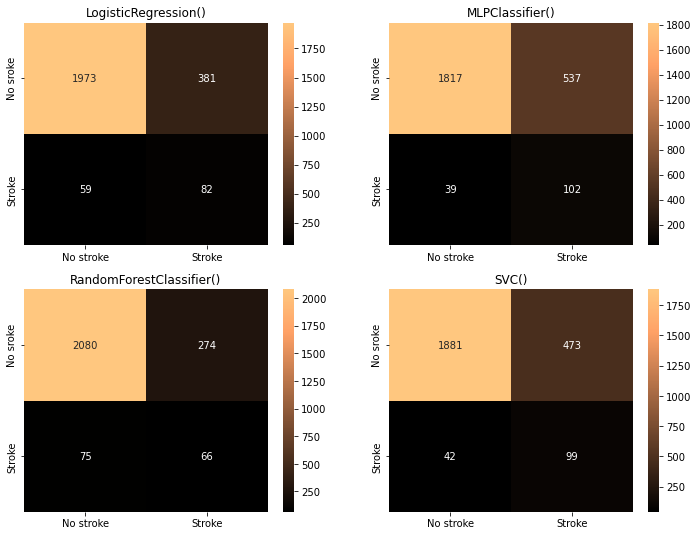

In [47]:
fig, axs = plt.subplots(2,2, figsize=(12,9))

axlist = axs.flatten()

for ax, s in zip(axlist, searches):
    y_pred = s.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=['No stroke', 'Stroke'], yticklabels=['No sroke', 'Stroke'])
    ax.set_title(s.estimator.named_steps.clf)
    
plt.show()

In [48]:
cv_metrics_out_of_sample = []

for s in searches:
    y_pred = s.predict(X_test)
    print(f'Classifier: {s.estimator.named_steps.clf} \n')
    print(f'Classification report:\n\n{classification_report(y_test, y_pred)} \n')
    cv_metrics_out_of_sample.append([x[1] for x in precision_recall_fscore_support(y_test, y_pred, zero_division=0)])

Classifier: LogisticRegression() 

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1009
           1       0.20      0.66      0.31        61

    accuracy                           0.83      1070
   macro avg       0.59      0.75      0.61      1070
weighted avg       0.93      0.83      0.87      1070
 

Classifier: MLPClassifier() 

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1009
           1       0.16      0.70      0.26        61

    accuracy                           0.77      1070
   macro avg       0.57      0.74      0.56      1070
weighted avg       0.93      0.77      0.83      1070
 

Classifier: RandomForestClassifier() 

Classification report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1009
           1       0.19      0.48      0.27        61

  

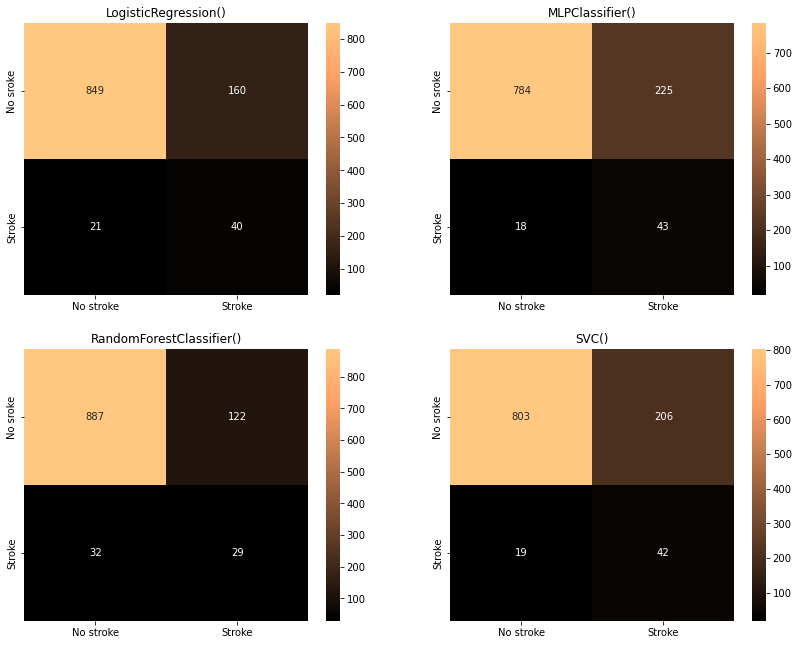

In [49]:
fig, axs = plt.subplots(2,2, figsize=(14,11))

axlist = axs.flatten()

for ax, s in zip(axlist, searches):
    y_pred = s.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=['No stroke', 'Stroke'], yticklabels=['No sroke', 'Stroke'])
    ax.set_title(s.estimator.named_steps.clf)
    
plt.show()

In [53]:
validation_type = ['Default in-sample', 'Default out-of-sample', 'CV in-sample', 'CV out-of-sample']

model_names = [m[1].__class__.__name__ for m in default_models]

metrics = ['Precision', 'Recall', 'F1-score', 'Support']

tuples = [(x, y) for (x,y) in itertools.product(model_names, validation_type)]

In [54]:
l =  []
for a, b, c, d in(zip(default_metrics_in_sample, default_metrics_out_of_sample, cv_metrics_in_sample, cv_metrics_out_of_sample)):
    temp = []
    for i in range(4):
        temp.append([a[i], b[i], c[i], d[i]])
    l.append(np.asarray(temp))    
    
all_metrics = np.hstack(l)

In [55]:
columns = pd.MultiIndex.from_tuples(tuples, names=['Model', 'Validation type'])
df_metrics = pd.DataFrame(all_metrics, index=metrics, columns=columns)
df_metrics[:-1]

Model           LogisticRegression                                     \
Validation type  Default in-sample Default out-of-sample CV in-sample   
Precision                  0.00000               1.00000      0.17711   
Recall                     0.00000               0.01639      0.58156   
F1-score                   0.00000               0.03226      0.27152   

Model                                          SVC                        \
Validation type CV out-of-sample Default in-sample Default out-of-sample   
Precision                0.20000           0.00000               0.00000   
Recall                   0.65574           0.00000               0.00000   
F1-score                 0.30651           0.00000               0.00000   

Model                                         RandomForestClassifier  \
Validation type CV in-sample CV out-of-sample      Default in-sample   
Precision            0.15962          0.16045                1.00000   
Recall               0.72340          0.70492                1.00000   
F1-score             0.26154          0.26140                1.00000   

Model                                                                \
Validation type Default out-of-sample CV in-sample CV out-of-sample   
Precision                     1.00000      0.19412          0.19205   
Recall                        0.03279      0.46809          0.47541   
F1-score                      0.06349      0.27443          0.27358   

Model               MLPClassifier                                     \
Validation type Default in-sample Default out-of-sample CV in-sample   
Precision                 0.83333               0.50000      0.17308   
Recall                    0.07092               0.06557      0.70213   
F1-score                  0.13072               0.11594      0.27770   

Model                             
Validation type CV out-of-sample  
Precision                0.16935  
Recall                   0.68852  
F1-score                 0.27184